This project examines a seasonal financial market anomaly, called the **january effect**.

The study:
- uses data of **15 market indicies** from around the world,
- examines the period between **1999:1 - 2019:12**,
- examines **3 categories of each** market based on market capitalization (small cap, mid cap, large cap).

For a more detailed explanation please take a look at the **readme file** on my github.

## Import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline
import seaborn as sns

import datetime
from statsmodels.graphics import tsaplots
import statsmodels.tsa
import scipy
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Data preparation

Creating 3 dataframes for the time series sorted into 3 groups, decided by market capitalization. From the 15 time series, i will create 45 as every market will have a **small cap**, a **mid cap** and a **large cap** time series.

I have downloaded the indices from the **MSCI website**.

In [2]:
# Importing time series

small_cap = pd.read_excel('MSCI.xls', sheet_name='Small cap').set_index(['DATE'])

mid_cap = pd.read_excel('MSCI.xls', sheet_name='Mid cap').set_index(['DATE'])

large_cap = pd.read_excel('MSCI.xls', sheet_name='Large cap').set_index(['DATE'])

In [3]:
# Creating a class for data preparation so I can use it later, if I need it for different market data.

class DataPrep():
    
    # This class contains useful functions to prepare the time series data for analysis.
    
    def __init__(self, data):
        self.data = data
        
    def get_info(self):
        print(self.data.info())
    
    def check_columns(self):
        print(self.data.columns)
        
    def remove_col_space(self):
        return self.data.columns.str.rstrip()
    

In [4]:
# Creating instances for the class DataPrep

sc = DataPrep(small_cap)
mc = DataPrep(mid_cap)
lc = DataPrep(large_cap)

In [5]:
# Checking number of null values and data types of columns

sc.get_info()
print("\n")
mc.get_info()
print("\n")
lc.get_info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 253 entries, 1998-12-31 to 2019-12-31
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   AUSTRALIA         253 non-null    float64
 1   BRAZIL            253 non-null    float64
 2   CANADA            253 non-null    float64
 3   FRANCE            253 non-null    float64
 4   GERMANY           253 non-null    float64
 5   HONG KONG         253 non-null    float64
 6   INDIA             253 non-null    float64
 7   ITALY             253 non-null    float64
 8   JAPAN             253 non-null    float64
 9   KOREA             253 non-null    float64
 10  NETHERLANDS       253 non-null    float64
 11  RUSSIA            253 non-null    float64
 12  SPAIN             253 non-null    float64
 13  UNITED KINGDOM    253 non-null    float64
 14  USA               253 non-null    float64
dtypes: float64(15)
memory usage: 31.6 KB
None


<class 'pandas.core.frame.Da

In [6]:
# Checking if there is a problem with column names

sc.check_columns()
print("\n")
mc.check_columns()
print("\n")
lc.check_columns()

Index(['AUSTRALIA  ', 'BRAZIL  ', 'CANADA  ', 'FRANCE  ', 'GERMANY  ',
       'HONG KONG  ', 'INDIA  ', 'ITALY  ', 'JAPAN  ', 'KOREA  ',
       'NETHERLANDS  ', 'RUSSIA  ', 'SPAIN  ', 'UNITED KINGDOM  ', 'USA  '],
      dtype='object')


Index(['AUSTRALIA  ', 'BRAZIL  ', 'CANADA  ', 'FRANCE  ', 'GERMANY  ',
       'HONG KONG  ', 'INDIA  ', 'ITALY  ', 'JAPAN  ', 'KOREA  ',
       'NETHERLANDS  ', 'RUSSIA  ', 'SPAIN  ', 'UNITED KINGDOM  ', 'USA  '],
      dtype='object')


Index(['AUSTRALIA  ', 'BRAZIL  ', 'CANADA  ', 'FRANCE  ', 'GERMANY  ',
       'HONG KONG  ', 'INDIA  ', 'ITALY  ', 'JAPAN  ', 'KOREA  ',
       'NETHERLANDS  ', 'RUSSIA  ', 'SPAIN  ', 'UNITED KINGDOM  ', 'USA  '],
      dtype='object')


In [7]:
# Need to remove spaces from the end of column names

small_cap.columns = sc.remove_col_space()
mid_cap.columns = mc.remove_col_space()
large_cap.columns = lc.remove_col_space()

## Visualization

Visualizing the 3 dataframes to explore if **further transformation** is needed.

In [8]:
# Creating function for visualizing indices

def plot_indices(data, title, xlabel, ylabel, color_num, grid_bool = False):
    
    fig = plt.figure(figsize=(6,4), dpi=100)
    axes = fig.add_axes([0.1,0.1,0.9,0.9])
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_title(title)
    
    if grid_bool == True: 
        axes.grid(True, dashes=(5,2,1,2))

    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.jet(np.linspace(0, 1, color_num))))
    plt.plot(data)
    plt.legend(data, loc="right", bbox_to_anchor=(1,0,0.5,1))

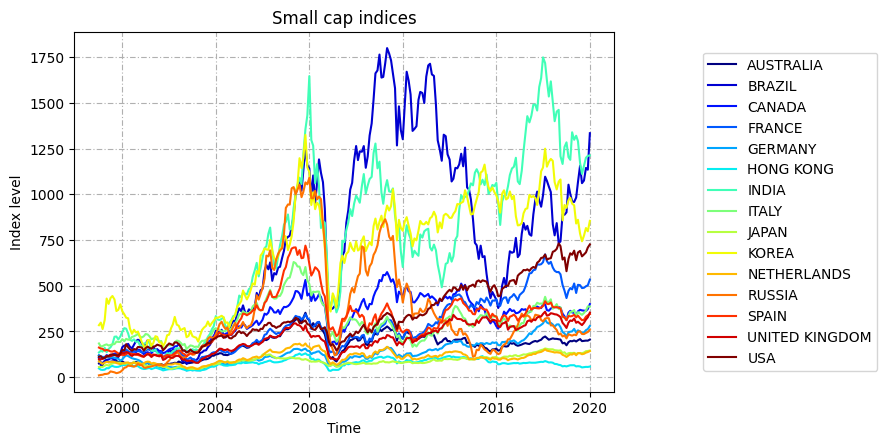

In [9]:
# PLotting small cap indices

plot_indices(small_cap, 'Small cap indices', 'Time', 'Index level', 15, True)

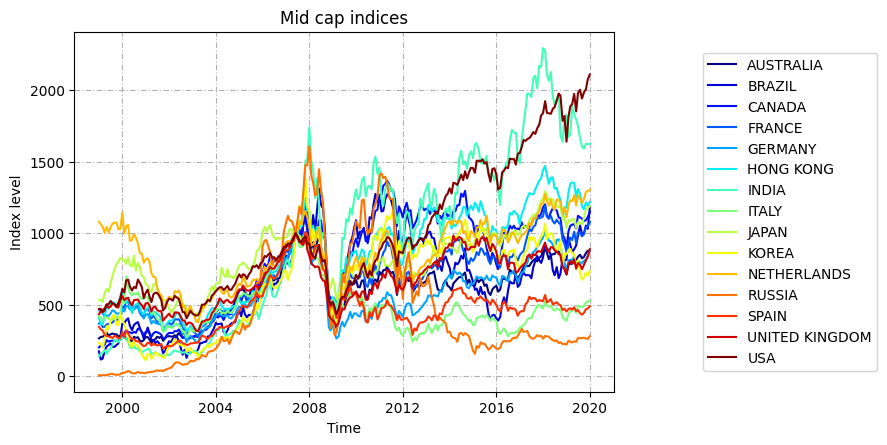

In [10]:
# PLotting mid cap indices

plot_indices(mid_cap, 'Mid cap indices', 'Time', 'Index level', 15, True)

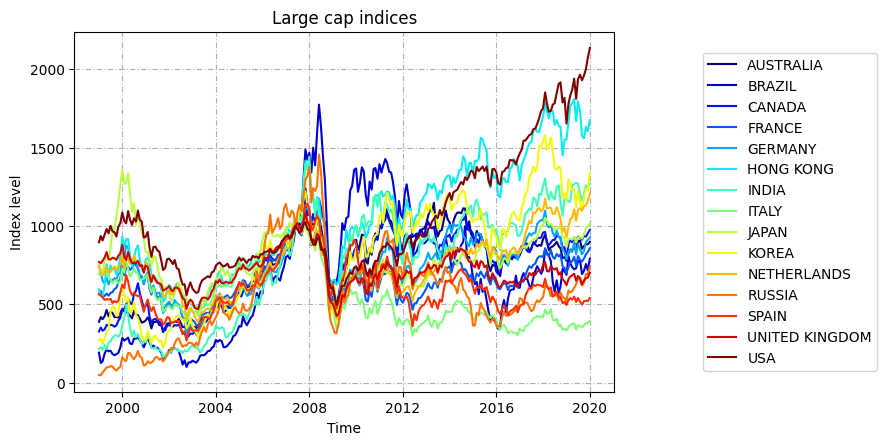

In [11]:
# PLotting large cap indices

plot_indices(large_cap, 'Large cap indices', 'Time', 'Index level', 15, True)

The visualizations suggest that the time series are **not stationary** as price data usually isn't.

In order to be able to model the anomaly, I turn the price data into **log returns** which are more likely to be stationary.

## Calculating log returns

In [12]:
# Creating function to create log returns

def log_return_calc(data):
    
    log_return = np.log(1 + data.pct_change()).dropna()
    
    return log_return

In [13]:
# Transform data into log returns

sc_log_return = log_return_calc(small_cap)
mc_log_return = log_return_calc(mid_cap)
lc_log_return = log_return_calc(large_cap)

In [14]:
# Checking one of the log return dataframes

sc_log_return.head()

,AUSTRALIA,BRAZIL,CANADA,FRANCE,GERMANY,HONG KONG,INDIA,ITALY,JAPAN,KOREA,NETHERLANDS,RUSSIA,SPAIN,UNITED KINGDOM,USA
DATE,,,,,,,,,,,,,,,
1999-01-29,0.068308,-0.477056,0.017281,-0.054281,-0.069195,-0.154175,0.063670,-0.097776,0.020333,0.048650,-0.101988,0.213919,-0.035558,-0.011564,0.018344
1999-02-26,-0.024920,0.018869,-0.048354,-0.024872,-0.031432,-0.029309,-0.030970,0.015149,-0.011185,-0.125264,-0.076210,0.075846,-0.006540,0.024742,-0.094275
1999-03-31,0.039867,0.319880,0.054812,-0.008379,-0.016094,0.038696,0.141377,0.035315,0.120505,0.172673,0.089152,0.283784,-0.067103,0.072739,0.004477
1999-04-30,0.070195,0.042816,0.114242,0.073755,0.055245,0.180702,-0.165006,0.020219,0.070552,0.318360,0.053799,0.023733,0.027763,0.083343,0.071748
1999-05-31,-0.067474,0.021314,-0.047488,-0.022670,-0.020216,-0.024506,0.127906,-0.038001,-0.069213,-0.070538,-0.023583,0.154054,-0.023872,-0.031844,0.033493


## Explore log returns

Examining the subplots of log returns for each location.

In [15]:
# A function to create subplots of the log returns

def log_return_subplot(data, title, nrow, ncol, cmap, sharex_bool = False):
    
    data.plot(subplots=True, layout=(nrow, ncol), figsize=(20,20), colormap=cmap, sharex=sharex_bool, title=title)


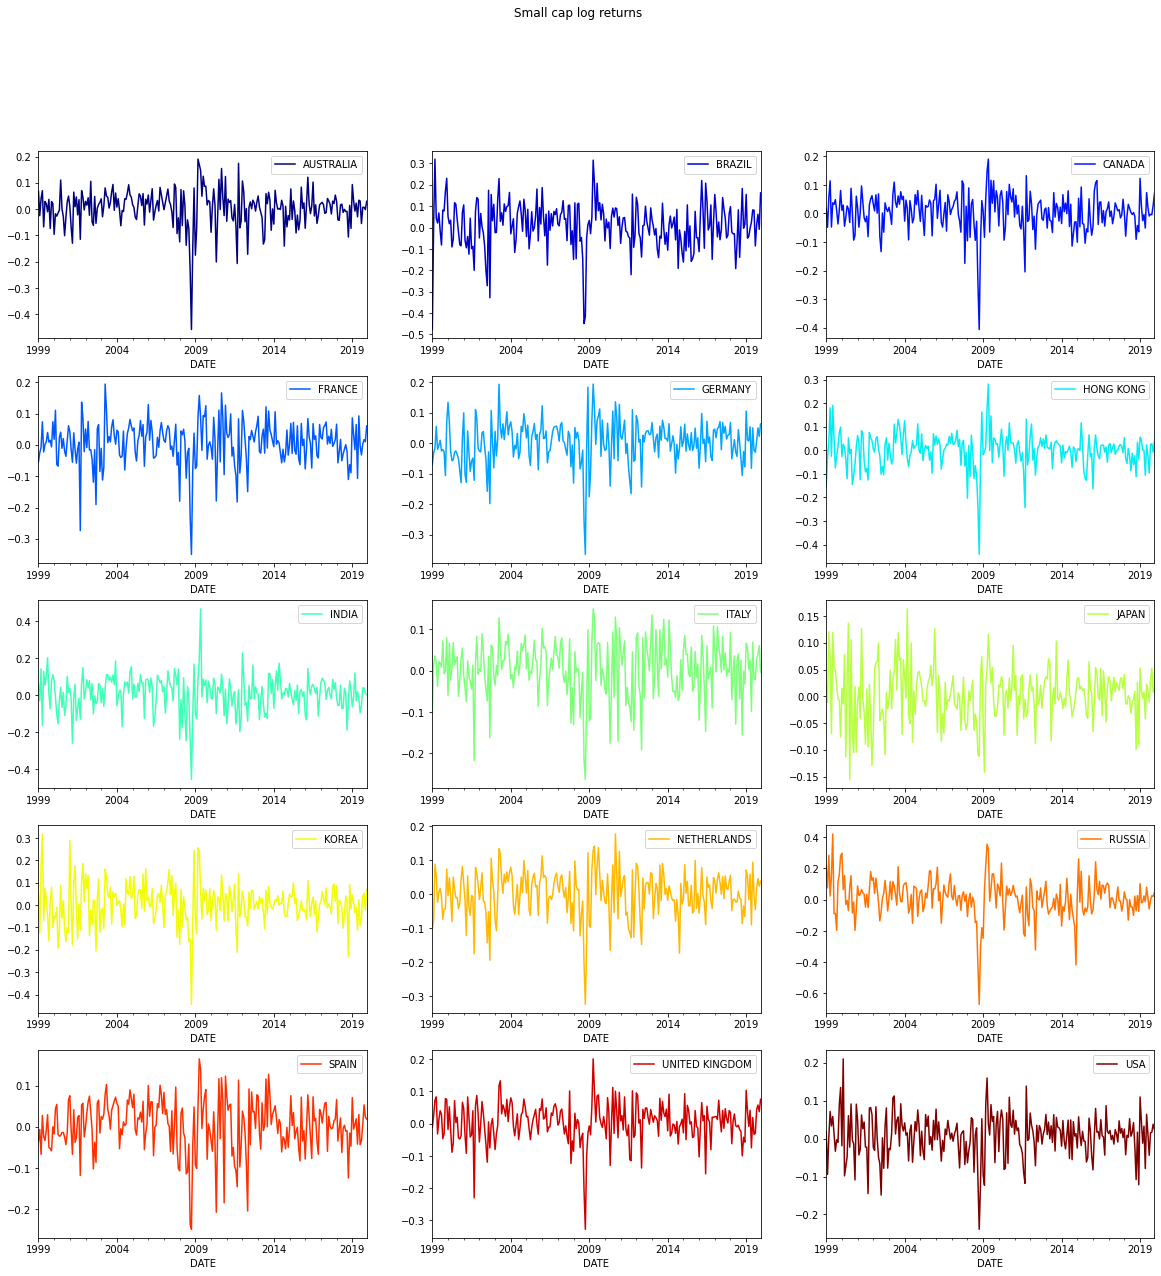

In [16]:
# Small cap log returns

log_return_subplot(sc_log_return, "Small cap log returns", 5, 3, "jet")

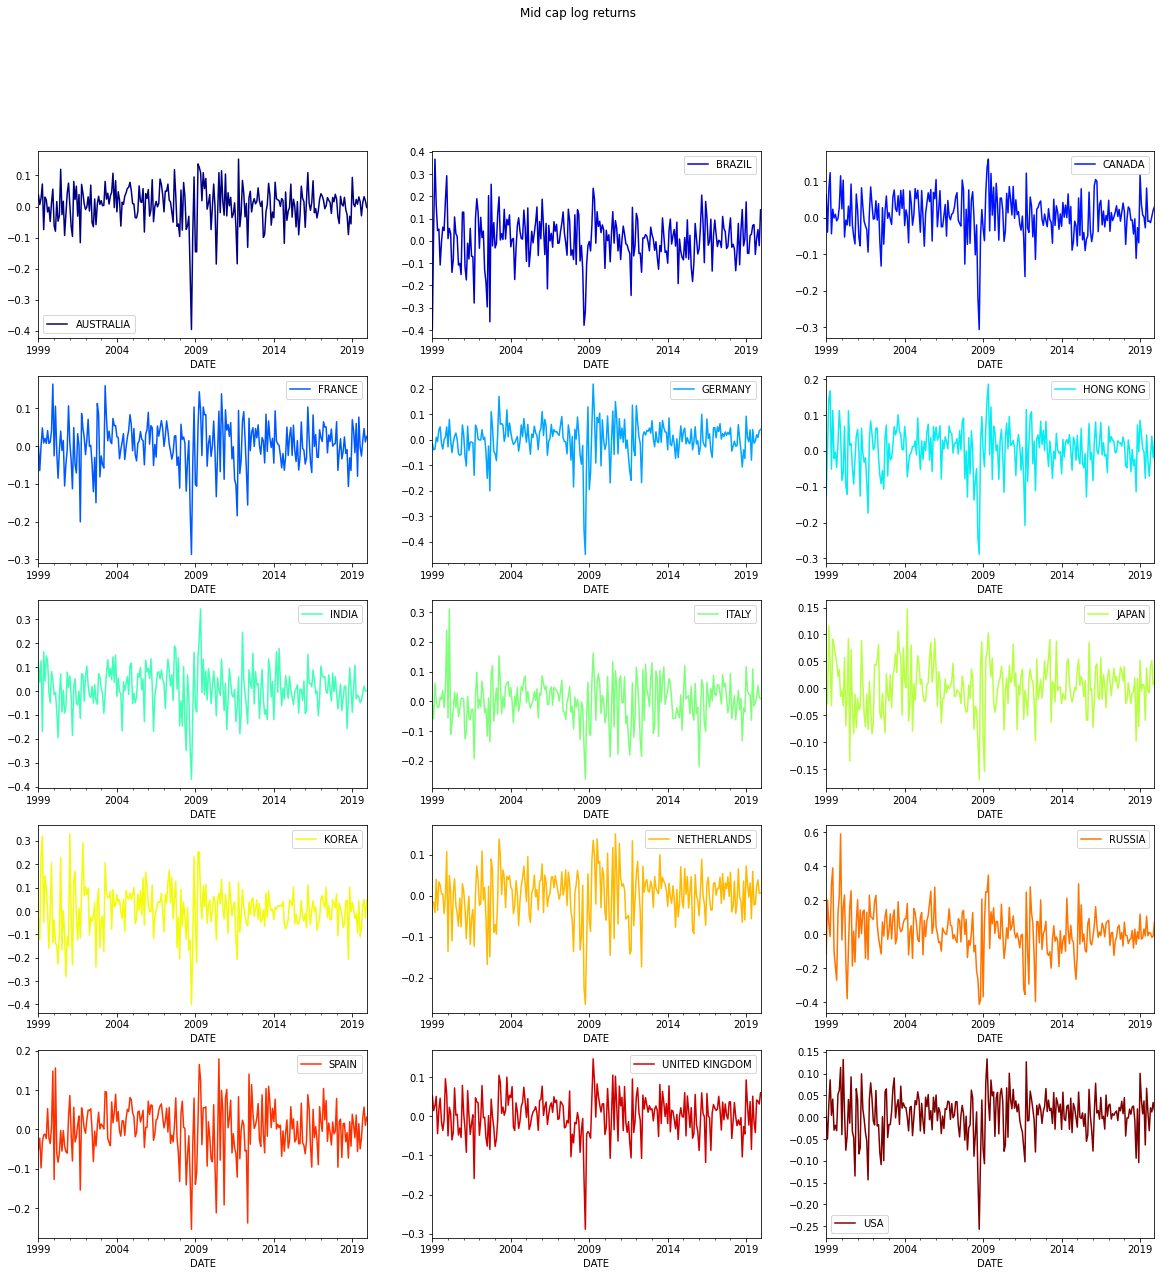

In [17]:
# Mid cap log returns

log_return_subplot(mc_log_return, "Mid cap log returns", 5, 3, "jet")

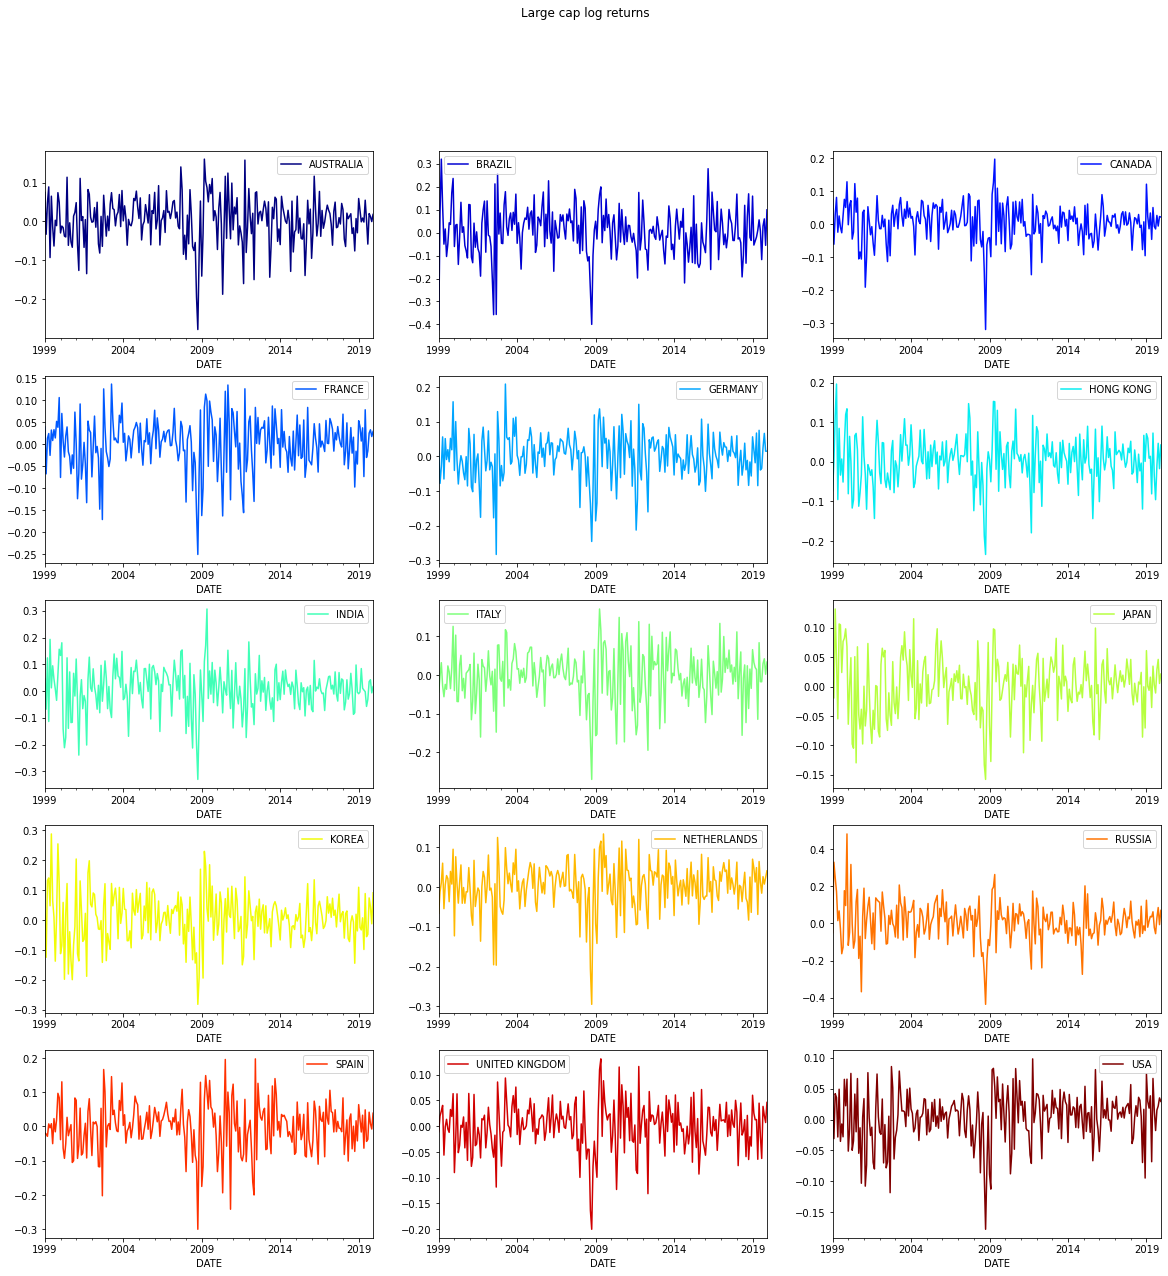

In [18]:
# Large cap log returns

log_return_subplot(lc_log_return, "Large cap log returns", 5, 3, "jet")

The transformation made the time series look more stationary, but I will run an **augmented Dickey–Fuller** test in a later section to test for unit roots.

## Autocorrelation

#### ACF plots

In this section I take a look at the autocorrelation functions of the time series.

In [19]:
# Defining function for ACF and PACF plots

def autocorrelation_plots(acf_or_pacf, data, nrow, ncol, suptitle, lags):
    
    fig, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(20,20))
    fig.suptitle(suptitle, fontsize=30)

    if acf_or_pacf == "acf":
        
        for ax, yvar in zip(axes.flat, data.columns):

            tsaplots.plot_acf(data[yvar], lags=lags, ax=ax);
            ax.set_title(yvar)
    
    elif acf_or_pacf == "pacf":
        
        for ax, yvar in zip(axes.flat, data.columns):

            tsaplots.plot_pacf(data[yvar], lags=lags, ax=ax);
            ax.set_title(yvar)
            
    else:
        print("For 'acf_or_pacf' type 'acf' or 'pacf'. ")

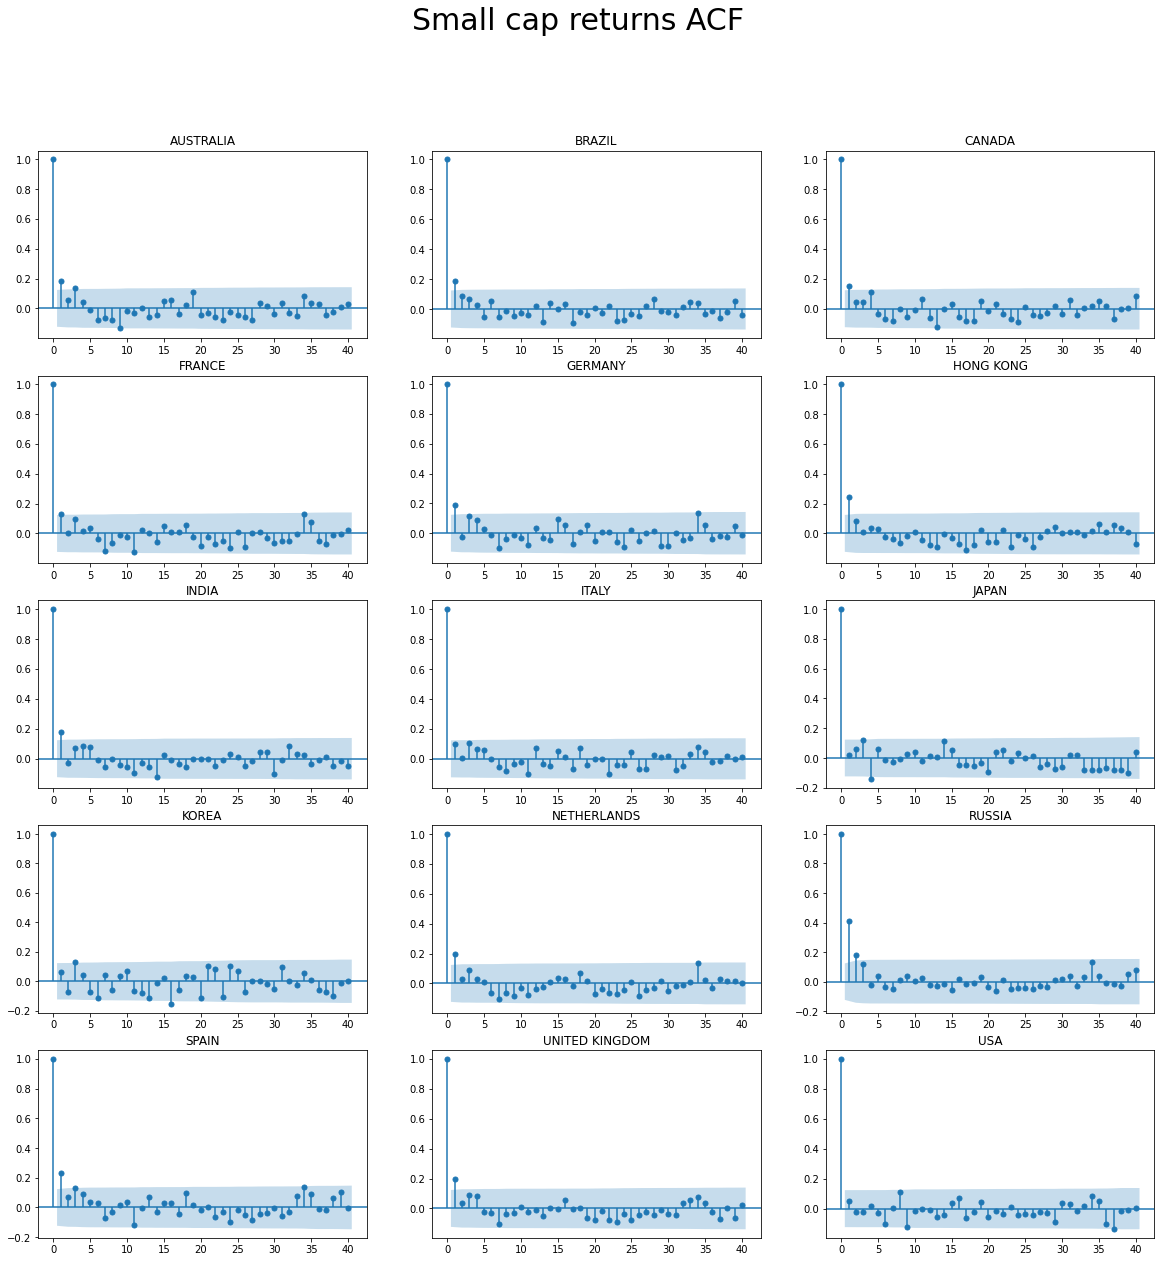

In [20]:
# Plotting ACF for small cap indices

autocorrelation_plots("acf", sc_log_return, 5,3, "Small cap returns ACF", 40)

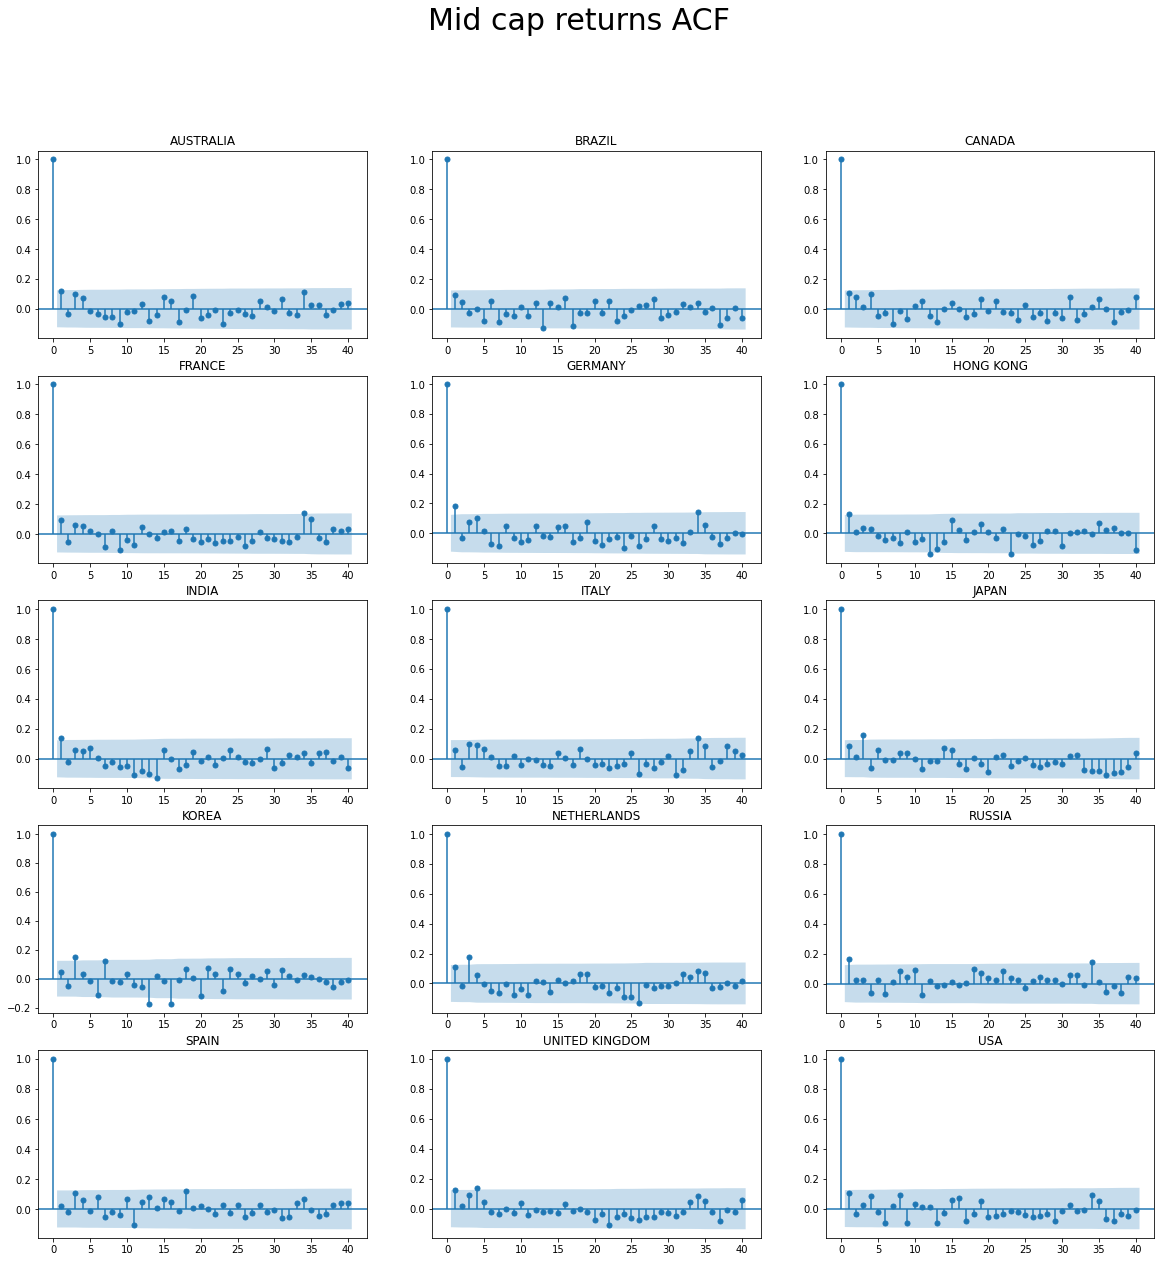

In [21]:
# Plotting ACF for mid cap indices

autocorrelation_plots("acf", mc_log_return, 5,3, "Mid cap returns ACF", 40)

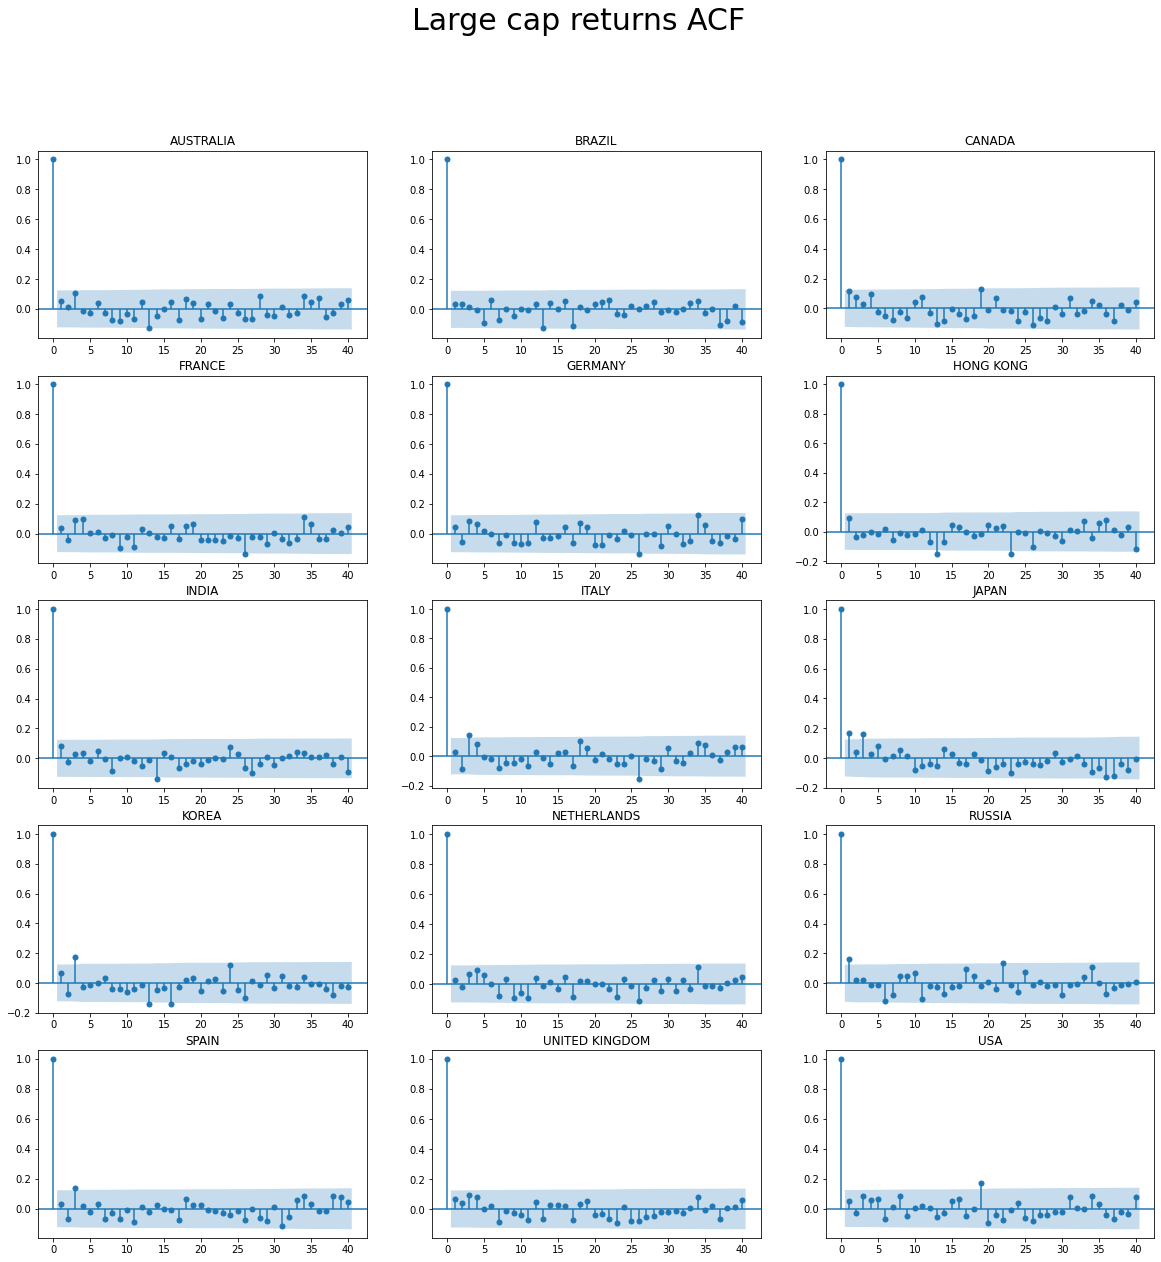

In [22]:
# Plotting ACF for large cap indices

autocorrelation_plots("acf", lc_log_return, 5,3, "Large cap returns ACF", 40)

#### PACF plots

Taking a look at **partial autocorrelation** functions.

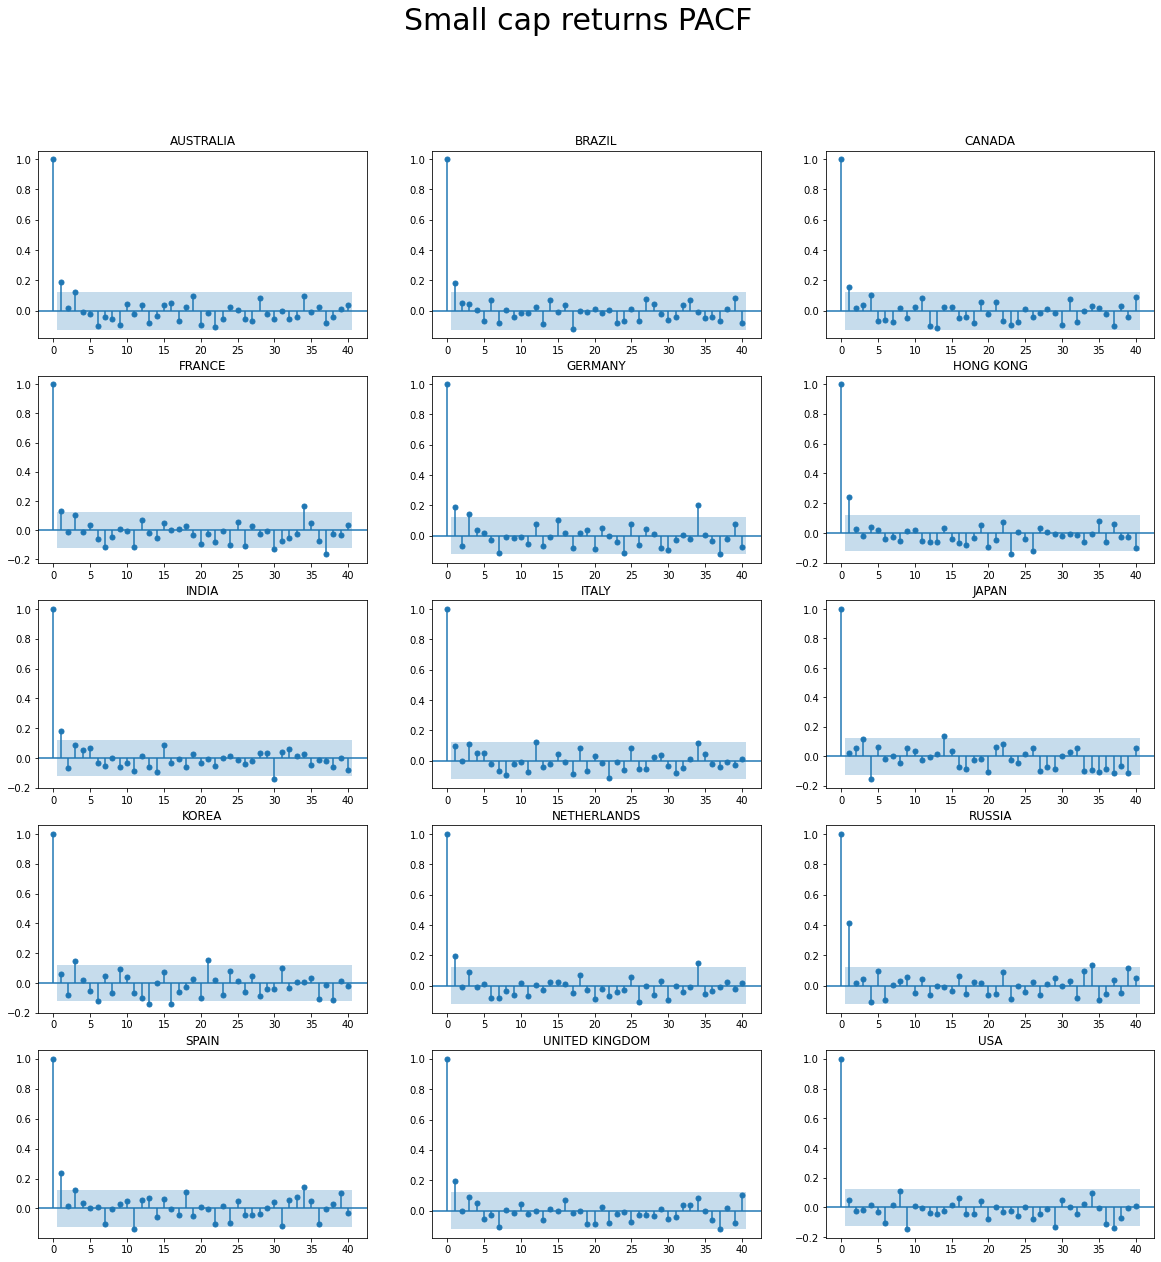

In [23]:
# Plotting PACF for small cap indices

autocorrelation_plots("pacf", sc_log_return, 5,3, "Small cap returns PACF", 40)

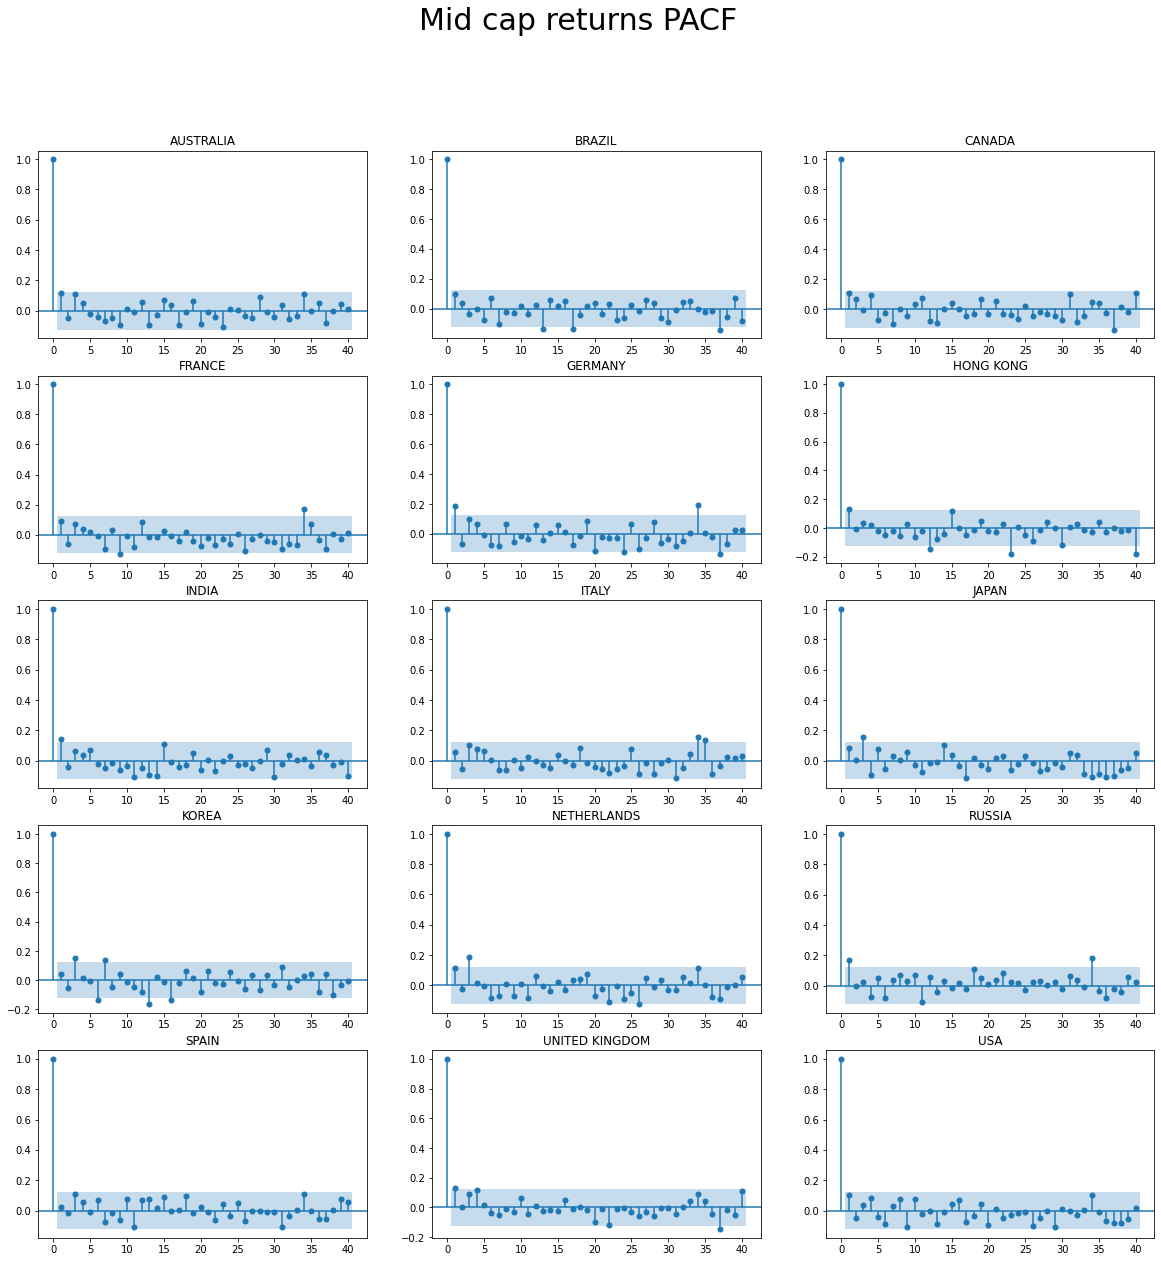

In [24]:
# Plotting PACF for mid cap indices

autocorrelation_plots("pacf", mc_log_return, 5,3, "Mid cap returns PACF", 40)

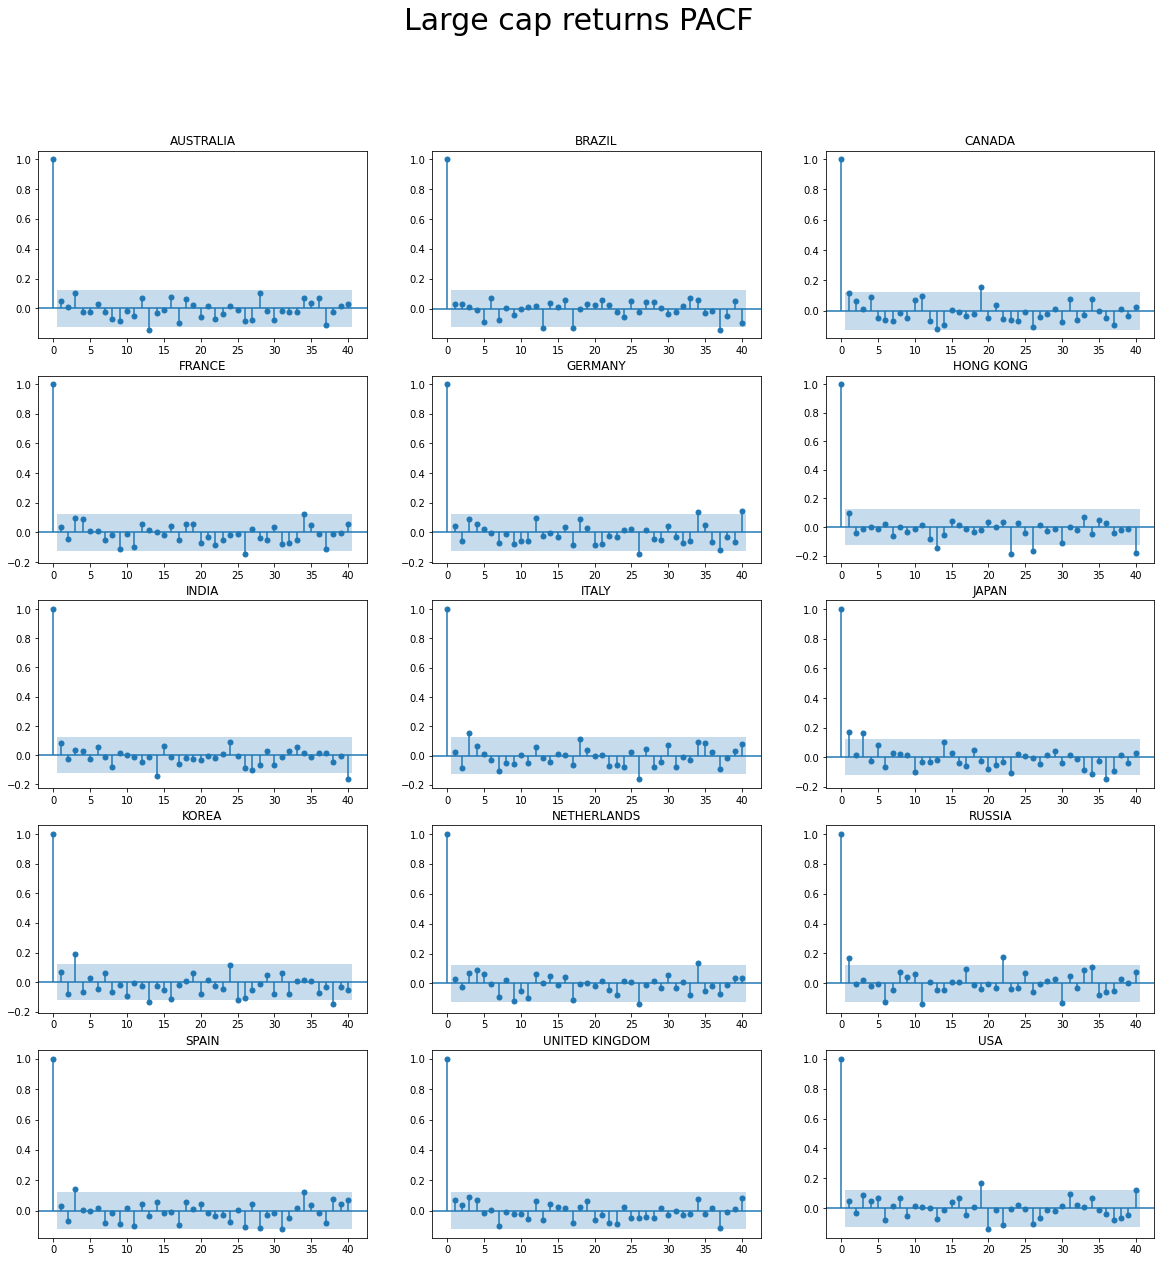

In [25]:
# Plotting PACF for large cap indices

autocorrelation_plots("pacf", lc_log_return, 5,3, "Large cap returns PACF", 40)

The ACF and PACF plots show that there is little if any autocorrelation in the 45 time series.

## Diagnostics

In [26]:
#  A class that will help me create reports and summaries easily 

class Diagnostics():
    
    def __init__(self, data):
        self.data = data

    def report(self):
        
        # This functions generates a report for me with the diagnostics of each market from a dataset
        
        data_mean = list(self.data.mean())
        data_std = list(self.data.std())
        data_skewness = list(self.data.skew())
        data_kurtosis = list(self.data.kurtosis())
        
        # augmented Dickey-Fuller test     
        data_adf_stat = []
        for i in self.data.columns:
            data_adf_stat.append(statsmodels.tsa.stattools.adfuller(self.data[i])[0])
        
        # augmented Dickey-Fuller test p-values
        data_adf_p = []
        for i in self.data.columns:
            data_adf_p.append(statsmodels.tsa.stattools.adfuller(self.data[i])[1])
        
        # create a dataframe that will be the report
        data_report = pd.DataFrame({'market':self.data.columns, 'mean':data_mean, 'std':data_std, 
                                    'kurtosis':data_kurtosis,'skewness':data_skewness, 
                                    'ADF':data_adf_stat, 'ADF(p)':data_adf_p}).set_index('market')
        
        return data_report
        
    def summary_line(self):
        # This function creates a short summary of diagnostics
        report_df = self.report()
        
        data_summary = pd.DataFrame({'mean':report_df['mean'].mean(), 'std':report_df['std'].mean(), 'kurtosis':report_df['kurtosis'].mean(),
                                     'skewness':report_df['skewness'].mean()}, index=[0])
        
        return data_summary

In [27]:
# Creating instances of the Diagnostics class

sc_diag = Diagnostics(sc_log_return)
mc_diag = Diagnostics(mc_log_return)
lc_diag = Diagnostics(lc_log_return)

#### Small cap diagnostics

In [28]:
sc_diag.report()

,mean,std,kurtosis,skewness,ADF,ADF(p)
market,,,,,,
AUSTRALIA,0.004002,0.070402,7.647324,-1.486627,-13.090823,1.790051e-24
BRAZIL,0.010121,0.109599,3.055794,-0.858974,-9.576469,2.216529e-16
CANADA,0.005321,0.065448,6.358233,-1.295887,-13.471147,3.380515e-25
FRANCE,0.005925,0.069232,3.786903,-1.055297,-13.811809,8.204892e-26
GERMANY,0.003453,0.069623,3.527604,-0.882605,-7.635344,1.959165e-11
HONG KONG,0.000783,0.073274,6.253320,-0.957918,-12.436174,3.842754e-23
INDIA,0.008712,0.095794,3.599079,-0.417119,-8.108461,1.244341e-12
ITALY,0.002931,0.068356,1.135858,-0.802063,-14.381244,9.145293e-27
JAPAN,0.003851,0.051282,0.780901,-0.130977,-8.169915,8.678506e-13


#### Mid cap diagnostics

In [29]:
mc_diag.report()

,mean,std,kurtosis,skewness,ADF,ADF(p)
market,,,,,,
AUSTRALIA,0.004734,0.062406,6.816071,-1.426558,-14.017147,3.625749e-26
BRAZIL,0.007588,0.106598,2.068730,-0.556890,-10.174552,6.947419e-18
CANADA,0.006892,0.058656,3.321291,-0.806692,-14.228623,1.610981e-26
FRANCE,0.004254,0.061719,2.237858,-0.765683,-14.391114,8.821481e-27
GERMANY,0.002554,0.071223,8.667040,-1.698039,-13.069607,1.969537e-24
HONG KONG,0.004318,0.064281,2.368926,-0.789896,-13.966497,4.423272e-26
INDIA,0.009714,0.088883,1.686228,-0.293911,-13.749831,1.055640e-25
ITALY,0.000946,0.073707,1.827286,-0.156738,-8.289177,4.307989e-13
JAPAN,0.003169,0.047217,0.862113,-0.271790,-7.427363,6.495416e-11


#### Large cap diagnostics

In [30]:
lc_diag.report()

,mean,std,kurtosis,skewness,ADF,ADF(p)
market,,,,,,
AUSTRALIA,0.003333,0.061181,2.033392,-0.712686,-15.023425,1.014504e-27
BRAZIL,0.005646,0.107985,1.856451,-0.517870,-10.601866,6.141671e-19
CANADA,0.004344,0.057440,4.051325,-0.911098,-14.097592,2.653455e-26
FRANCE,0.001677,0.059385,1.373429,-0.703850,-15.253464,4.972475e-28
GERMANY,0.001147,0.067470,1.979360,-0.682703,-15.123499,7.402640e-28
HONG KONG,0.004107,0.061179,1.264656,-0.300060,-14.375826,9.328352e-27
INDIA,0.007052,0.083466,1.403217,-0.416524,-14.527003,5.407977e-27
ITALY,-0.002539,0.068151,0.893228,-0.525973,-8.128715,1.105048e-12
JAPAN,0.001515,0.049194,0.334695,-0.281040,-13.274065,7.930543e-25


#### Summaries

In [31]:
# small cap summaries

sc_diag.summary_line()

,mean,std,kurtosis,skewness
0,0.00533,0.075472,3.610643,-0.802013


In [32]:
# mid cap summaries

mc_diag.summary_line()

,mean,std,kurtosis,skewness
0,0.004916,0.073266,2.915428,-0.670439


In [33]:
# large cap summaries

lc_diag.summary_line()

,mean,std,kurtosis,skewness
0,0.003219,0.068435,1.76103,-0.534518


The ADF tests show no unit roots for all the time series, so we can treat them as stationary.

One explanation for the anomaly is that the small companies are the driving force of the january effect. From the diagnostics, we can see, that as the company size increases, the time series are less skewed, they have less kurtosis and the mean is lower as well.

## Modeling

I chose to use an **OLS regression** model with dummy variables indicating the month.

I also decided to use **Newey-West standard errors (HAC)** againts heteroskedasticity and autocorrelation.

One could also use a volatility model from the GARCH family. Either a symmetrical one (GARCH(1,1)) or  an asymetrical one (EGARCH, GJR-GARCH). The arch library could be used for that, although the mean equation would be tricky and tiresome to pull off.

$$R_{i,t} = \sum\limits_{j=1}^{12}\beta_{i,j}D_{j,t} + \epsilon_{i,t}$$

Where $R_{i,t}$ is the stock return in the given month, $D_{j,t}$ is a dummy variable taking 1 for month $j$ and 0 otherwise, $\beta_{i,j}$ is a regression coefficient to be estimated, and $\epsilon_{i,t}$ is the error term.

In [68]:
class TSModel():
    
    def __init__(self, data):
        self.data = data
        
    def month_col(self):
        
        # Creates a month column for the modeling
        self.data['MONTH'] = self.data.index.month
        
    def OLS_model(self,lags):
        
        # Creates a df for the parameters and one for the pvalues of the model
        
        month_names = pd.Series(self.data.index.month_name()).drop_duplicates()
        
        pvalues = pd.DataFrame(columns=self.data.columns)
        pvalues["MONTH"] = month_names
        params = pd.DataFrame(columns=self.data.columns)
        params["MONTH"] = month_names
        
        for num, elem in zip(range(1,16), self.data.columns):
            reg_num = (smf.ols('Q(elem)' + " ~ C(MONTH)-1", self.data)
                    .fit()
                    .get_robustcov_results(cov_type="HAC", maxlags=lags))
                       
            pvalues[elem] = pd.Series(reg_num.pvalues)
            params[elem] = pd.Series(reg_num.params)
        
        pvalues = pvalues.set_index("MONTH")
        params = params.set_index("MONTH")
        
        return params, pvalues
    

In [69]:
# Create instances for class TSModel

sc_model = TSModel(sc_log_return)
mc_model = TSModel(mc_log_return)
lc_model = TSModel(lc_log_return)

In [36]:
# Create a month column for the model

sc_model.month_col()
mc_model.month_col()
lc_model.month_col()

In [70]:
# Dataframes with the results
sc_result = sc_model.OLS_model(18)
mc_result = mc_model.OLS_model(18)
lc_result = lc_model.OLS_model(18)

## Presenting the Results

Text(0.5, 1.0, 'Large cap coefficients')

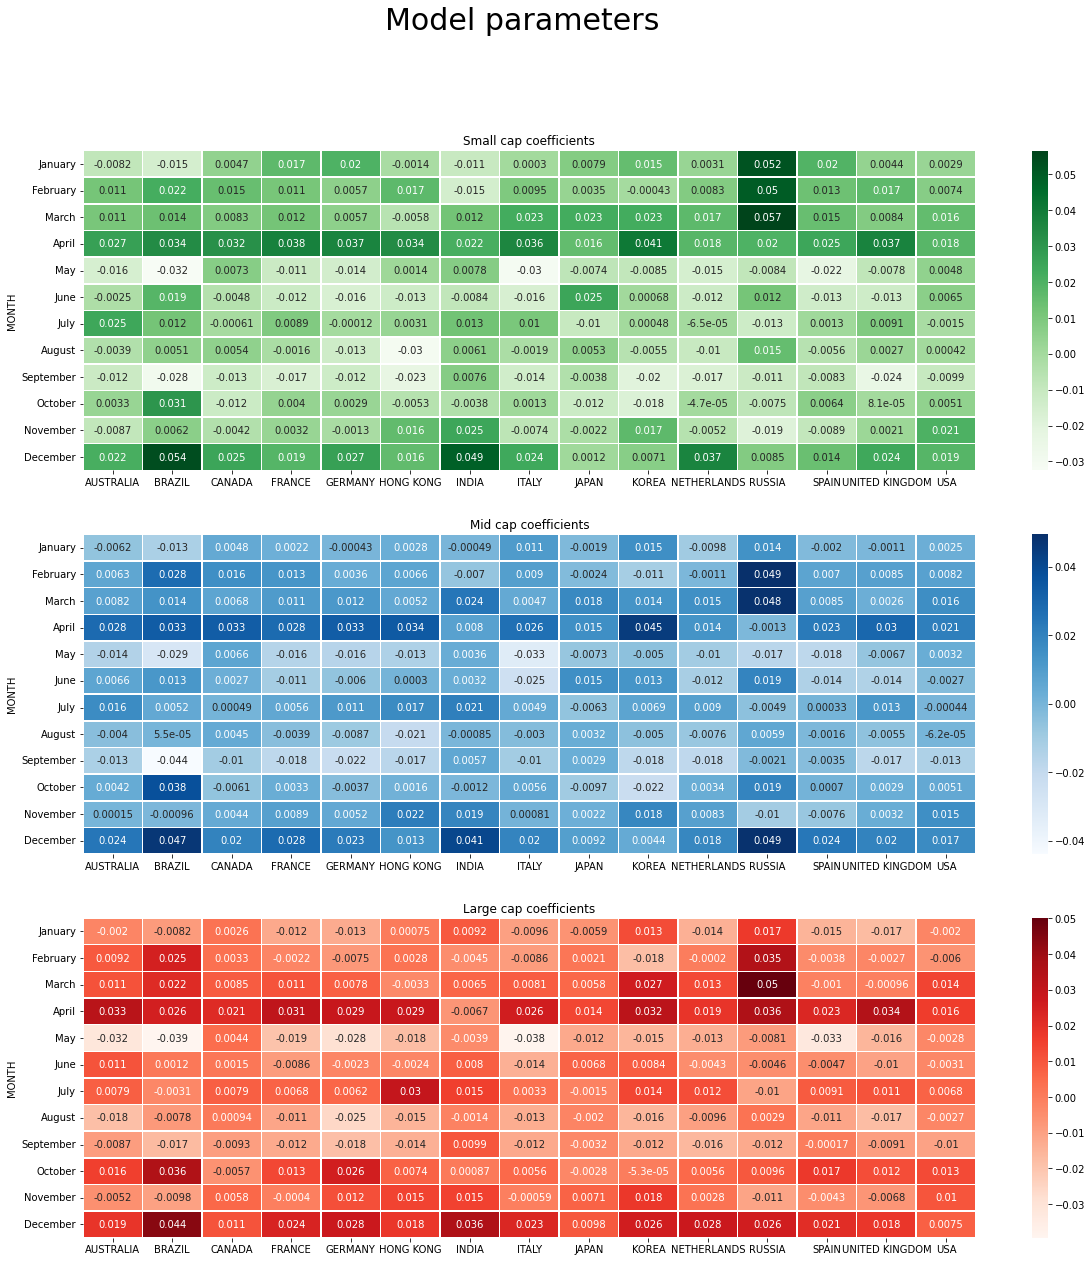

In [73]:
# Creating subplots of all the parameters for all indices

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,20))
fig.suptitle("Model parameters", fontsize=30, x=0.43)


sns.heatmap(sc_result[0], ax=axes[0], linewidth=.5, cmap="Greens", annot=True)
axes[0].set_title("Small cap coefficients")

sns.heatmap(mc_result[0], ax=axes[1], linewidth=.5, cmap="Blues", annot=True)
axes[1].set_title("Mid cap coefficients")

sns.heatmap(lc_result[0], ax=axes[2], linewidth=.5, cmap="Reds", annot=True)
axes[2].set_title("Large cap coefficients")

Text(0.5, 1.0, 'Large cap p-values')

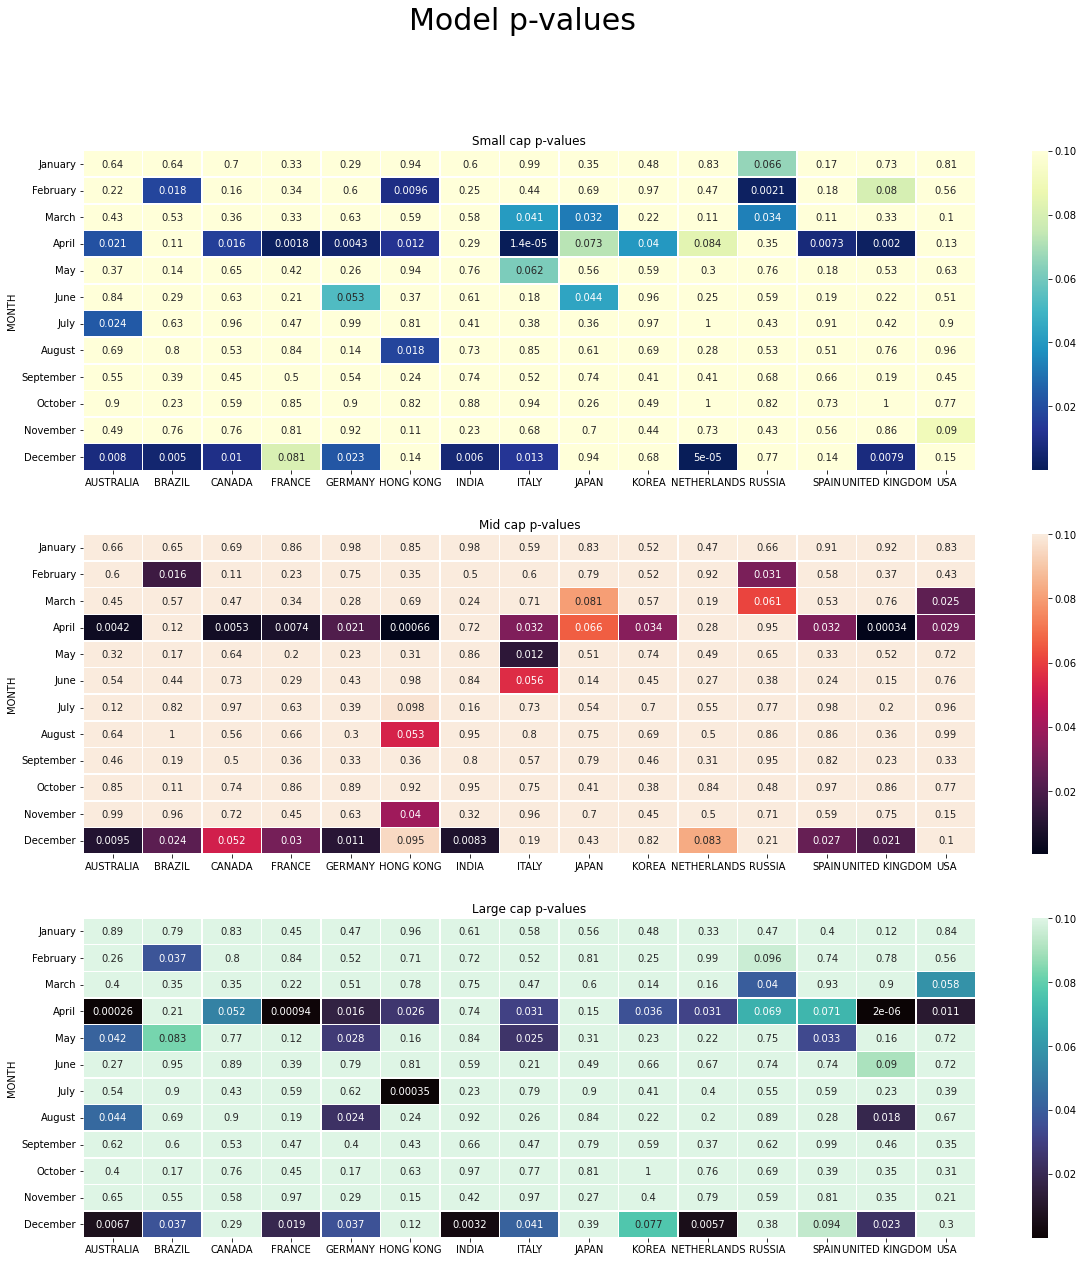

In [72]:
# Creating subplots of all the p-values for all indices

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20,20))
fig.suptitle("Model p-values", fontsize=30, x=0.43)


sns.heatmap(sc_result[1], ax=axes[0], linewidth=.5, vmax=0.1, cmap="YlGnBu_r", annot=True)
axes[0].set_title("Small cap p-values")

sns.heatmap(mc_result[1], ax=axes[1], linewidth=.5, vmax=0.1, cmap="rocket", annot=True)
axes[1].set_title("Mid cap p-values")

sns.heatmap(lc_result[1], ax=axes[2], linewidth=.5, vmax=0.1, cmap="mako", annot=True)
axes[2].set_title("Large cap p-values")

## Conclusion

From the model it is clear that the **January Effect is not present** in these markets. It was only statistically significant in Russia for the small capitalization index.

On the other hand 2 months produced very significant positive returns on average. **April and December** are important in all 3 capitalization categories. They are also significant in numerous countries.

Even though I reject the January Effect from these time series, the results show that **investors could benefit** from the returns in April and December.